<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/V3_COMPAS_Clustering_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

# LOAD (META) DATA

In [55]:
data_shaperr = pd.read_csv('/content/Compas_w_error_shap.csv')
data_shaper = data_shaperr.drop(['sex', 'race', 'predicted_class', 'true_class'], axis=1)
#data_shaperr.head()
#data_shaperr.info()
data_shaper.iloc[3]

age_unscaled                                  31.0
decile_score_unscaled                          7.0
priors_count_unscaled                          0.0
sex_Female_unscaled                            0.0
sex_Male_unscaled                              1.0
race_African-American_unscaled                 1.0
race_Asian_unscaled                            0.0
race_Caucasian_unscaled                        0.0
race_Hispanic_unscaled                         0.0
race_Native American_unscaled                  0.0
race_Other_unscaled                            0.0
age_scaled                               -0.321161
decile_score_scaled                       0.871941
priors_count_scaled                       -0.71124
sex_Female_scaled                        -0.489624
sex_Male_scaled                           0.489624
race_African-American_scaled              0.975623
race_Asian_scaled                         -0.06675
race_Caucasian_scaled                    -0.718015
race_Hispanic_scaled           

In [56]:
#Master Dataset
META_COL = ['clusters', 'new_clusters']
ERROR_COL = ['errors', 'TP', 'TN', 'FN', 'FP']
BASIC_COL_unscaled = ['age_unscaled', 'decile_score_unscaled', 'priors_count_unscaled']
DUMMY_unscaled = ['sex_Female_unscaled', 'sex_Male_unscaled','race_African-American_unscaled', 'race_Asian_unscaled', 'race_Caucasian_unscaled', 'race_Hispanic_unscaled',
                      'race_Native American_unscaled', 'race_Other_unscaled']

ERROR_COL_scaled = ['scaled_errors', 'scaled_TP', 'scaled_TN', 'scaled_FN', 'scaled_FP']
BASIC_COL_scaled = ['age_scaled', 'decile_score_scaled', 'priors_count_scaled']
DUMMY_scaled = ['sex_Female_scaled', 'sex_Male_scaled', 'race_Native American_scaled','race_Other_scaled',
                'race_African-American_scaled', 'race_Asian_scaled', 'race_Caucasian_scaled', 'race_Hispanic_scaled']

SHAP_COL_Basic_scaled = ['Shap_age_basicscaled', 'Shap_decile_score_basicscaled', 'Shap_priors_count_basicscaled']
SHAP_COL_Dummy_scaled = ['Shap_sex_Female_basicscaled', 'Shap_sex_Male_basicscaled',
                         'Shap_race_African-American_basicscaled', 'Shap_race_Asian_basicscaled', 'Shap_race_Caucasian_basicscaled',
                         'Shap_race_Hispanic_basicscaled', 'Shap_race_Native American_basicscaled', 'Shap_race_Other_basicscaled']

Scaled_SHAP_COL_Basic = ['scaled_shap_age_basicscaled', 'scaled_Shap_decile_score_basicscaled', 'scaled_Shap_priors_count_basicscaled']

Scaled_SHAP_COL_Dummy = ['scaled_Shap_sex_Female_basicscaled', 'scaled_Shap_sex_Male_basicscaled''scaled_Shap_race_African-American_basicscaled',
                     'scaled_Shap_race_Asian_basicscaled', 'scaled_Shap_race_Caucasian_basicscaled','scaled_Shap_race_Hispanic_basicscaled',
                     'scaled_Shap_race_Native American_basicscaled', 'scaled_Shap_race_Other_basicscaled']

META_COL_VIZ = ['Error_Type']

# DATA PREP UTILS

In [57]:
#Seperate TPFN & TNFP dataset
'''Drop rows where both TP and FN are 0 '''
def drop_zero_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def drop_zero_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

TPFN_all = drop_zero_TP_FN(data_shaper)
TNFP_all = drop_zero_TN_FP(data_shaper)

#scaled and unscaled version
TPFN_scaled = TPFN_all.drop(BASIC_COL_unscaled + DUMMY_unscaled, axis=1)
TPFN_unscaled = TPFN_all.drop(BASIC_COL_scaled + DUMMY_scaled, axis=1)
TNFP_scaled = TNFP_all.drop(BASIC_COL_unscaled + DUMMY_unscaled, axis=1)
TNFP_unscaled = TNFP_all.drop(BASIC_COL_scaled + DUMMY_scaled, axis=1)

#TNFP.head()
TPFN_scaled.iloc[3]
#TNFP_unscaled.iloc[3]

age_scaled                                2.707078
decile_score_scaled                      -1.228754
priors_count_scaled                      -0.301588
sex_Female_scaled                        -0.489624
sex_Male_scaled                           0.489624
race_African-American_scaled             -1.024986
race_Asian_scaled                         -0.06675
race_Caucasian_scaled                     1.392728
race_Hispanic_scaled                     -0.311212
race_Native American_scaled              -0.050014
race_Other_scaled                        -0.234822
errors                                         0.0
TP                                             1.0
TN                                             0.0
FN                                             0.0
FP                                             0.0
Error_Type                                      TP
Shap_age_basicscaled                      0.019492
Shap_decile_score_basicscaled             0.055606
Shap_priors_count_basicscaled  

In [58]:
#drop Na's
TPFN_scaled = TPFN_scaled.dropna()
TPFN_unscaled = TPFN_unscaled.dropna()
TNFP_scaled = TNFP_scaled.dropna()
TNFP_unscaled = TNFP_unscaled.dropna()

In [95]:
'''New Initialization Function for Dataset. Returns a dataset with scaled features and new columns for clusters = 0 and new_clusters = -1 which is required for HBAC'''


def initialize_dataset(data, unscaled=True, meta_col=True, with_classes=True):
    """
    Prepare the dataset by scaling the unscaled features and adding cluster columns.

    PARAM:
    - data: The input dataset.
    - unscaled (bool): If True, scales all features including unscaled basic and dummy features.
                       If False, scales only SHAP and ERROR columns.
    - meta_col (bool): If True, keeps META_COL in the final dataset.
    - with_classes (bool): If True, retains class columns from META_COL in the new dataset.

    Returns:
    - pd.DataFrame: The preprocessed dataset with scaled features and initialized cluster columns.
    """

    # 1. Make deep copy of the dataset
    new_data = data.copy(deep=True)

    # 2. Ignore cluster and new cluster for scaling and add them back in step 4
    if meta_col:
        new_data = new_data.drop(columns=META_COL + ['clusters', 'new_clusters'], errors='ignore')

    # 3. Define features to scale
    if unscaled:
        features_to_scale = SHAP_COL_Dummy_scaled + SHAP_COL_Basic_scaled + ERROR_COL + BASIC_COL_unscaled + DUMMY_unscaled
    else:
        features_to_scale = SHAP_COL_Dummy_scaled + SHAP_COL_Basic_scaled + ERROR_COL

    # Scale features
    scaler = StandardScaler()
    new_data[features_to_scale] = scaler.fit_transform(new_data[features_to_scale])

    # 4. Add back META_COL if required
    if with_classes:
        for col in META_COL:
            if col in data.columns:
                new_data[col] = data[col]

    # Initialize clusters and new_clusters columns
    new_data['clusters'] = 0
    new_data['new_clusters'] = -1

    return new_data

# Example usage
TPFN_init = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_classes=True)
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_classes=True)
# TPFN_scaled2 = initialize_dataset(TPFN_scaled, unscaled=False, meta_col=True, with_classes=True) # Will give the same dataset
# TNFP_scaled2 = initialize_dataset(TNFP_scaled, unscaled=False, meta_col=True, with_classes=True) # Will give the same dataset



In [96]:
#TPFN_init.iloc[3]
TNFP_init.iloc[3]

age_unscaled                             -0.022071
decile_score_unscaled                    -1.012897
priors_count_unscaled                    -0.644568
sex_Female_unscaled                       1.816288
sex_Male_unscaled                        -1.816288
race_African-American_unscaled            1.098943
race_Asian_unscaled                      -0.071685
race_Caucasian_unscaled                   -0.77333
race_Hispanic_unscaled                   -0.332765
race_Native American_unscaled            -0.050624
race_Other_unscaled                      -0.264616
errors                                   -0.702232
TP                                             0.0
TN                                        0.702232
FN                                             0.0
FP                                       -0.702232
Error_Type                                      TN
Shap_age_basicscaled                     -0.509456
Shap_decile_score_basicscaled            -1.446602
Shap_priors_count_basicscaled  

In [97]:
'''undo Dummy for DUMMY_RACE or DUMMY_GENDER'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)

# UTILS for BIAS in ERROR DIFFERENCE

In [98]:
#Calculate average Error rate based on unscaled error rate by counting the amount of max values (1) and dividing them by the total nr of rows - replacing old accuracy_error() V1
def get_error_rate(data, column = 'errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty cluster')
    return
  max_value = data[column].max()
  count_max_value = (data[column] == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate

'''Calculate BIAS in terms of Error Difference
bias_type can be 'negative', 'positive' or 'absolute'
baseline can be 'all' which is the overall error rate, or 'other' or 'best' '''

def get_error_diff(data, cluster_id, cluster_col, bias_type = 'negative', baseline= 'all'):
  cluster_x= data.loc[data[cluster_col] == cluster_id]
  remaining_clusters = data.loc[data[cluster_col] != cluster_id]

  if len(cluster_x) == 0:
    print ('calculating error difference on an empty cluster')
    return

  if baseline == 'all':
    error_diff = get_error_rate(cluster_x) - get_error_rate(data)

  elif baseline == 'other':
    if len(remaining_clusters) == 0:
      print ("This cluster is the entire dataset. Cluster:", cluster_id)
      return
    error_diff = get_error_rate(cluster_x) - get_error_rate(remaining_clusters)

  elif baseline == 'best':
    best_cluster = get_min_bias_cluster(data, cluster_col, bias_type, baseline)
    error_diff = get_error_rate(cluster_x) - best_cluster[1]

  else:
    print ('unknown baseline')
    return

  #if full_info:
    #return [error_diff, function(cluster_x), function(remaining_clusters)]

  if bias_type == 'negative':
    pass #no change needed
  elif bias_type == 'positive':
    error_diff = -error_diff
  elif bias_type == 'absolute':
    error_diff = np.absolute(error_diff)
  else:
    print("unknown bias type")
    return

  return error_diff

# UTILS for VISUALS

In [120]:
def pca_plot(data, title, alpha):
    # Extract features for PCA and drop Meta_colums
    pca_features = data.drop(META_COL + ERROR_COL_scaled, axis=1)

    # Keep only numeric columns so not Error_Type
    pca_features_numeric = pca_features.select_dtypes(include=[np.number])

    # Extract other features (META_COL + ERROR_COL_scaled) and ensure Error_Type is included
    other_features = data[META_COL + ERROR_COL_scaled]

    # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(pca_features_numeric)
    pca_df = pd.DataFrame(pca_result, index=pca_features_numeric.index, columns=['PC1', 'PC2'])

      # Ensure Error_Type is in the other_features
    if 'Error_Type' in data.columns:
        pca_df['Error_Type'] = data['Error_Type']

    # Create temporary dataset that contains both principal components and other features
    temp_dataset = pca_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='PC1', y='PC2', alpha=alpha, hue="clusters", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

def tsne_plot(data, error_type, perplexity, learning_rate, n_iter, alpha=0.5):

    # Extract features for TSNE and drop Meta_colums
    title = f'K-means for {error_type}'
    tsne_features = data.drop(META_COL + ERROR_COL, axis=1)

    # Keep only numeric columns so not Error_Type
    tsne_features_numeric = tsne_features.select_dtypes(include=[np.number])

    # Extract other features (META_COL + ERROR_COL_scaled) and ensure Error_Type is included
    other_features = data[META_COL + ERROR_COL]

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    tsne_result = tsne.fit_transform(tsne_features_numeric)  # Use numeric df for TSNE
    tsne_df = pd.DataFrame(tsne_result, index=tsne_features_numeric.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    # Ensure Error_Type is in the other_features
    if 'Error_Type' in data.columns:
        tsne_df['Error_Type'] = data['Error_Type']

    temp_dataset = tsne_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, hue="clusters", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.show()

# Example usage
#tsne_plot(TPFN_init, 'Compas for TP and FN', 30, 200, 1000)

In [100]:
TPFN_init.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1589 entries, 0 to 3543
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   age_unscaled                            1589 non-null   float64
 1   decile_score_unscaled                   1589 non-null   float64
 2   priors_count_unscaled                   1589 non-null   float64
 3   sex_Female_unscaled                     1589 non-null   float64
 4   sex_Male_unscaled                       1589 non-null   float64
 5   race_African-American_unscaled          1589 non-null   float64
 6   race_Asian_unscaled                     1589 non-null   float64
 7   race_Caucasian_unscaled                 1589 non-null   float64
 8   race_Hispanic_unscaled                  1589 non-null   float64
 9   race_Native American_unscaled           1589 non-null   float64
 10  race_Other_unscaled                     1589 non-null   float64
 

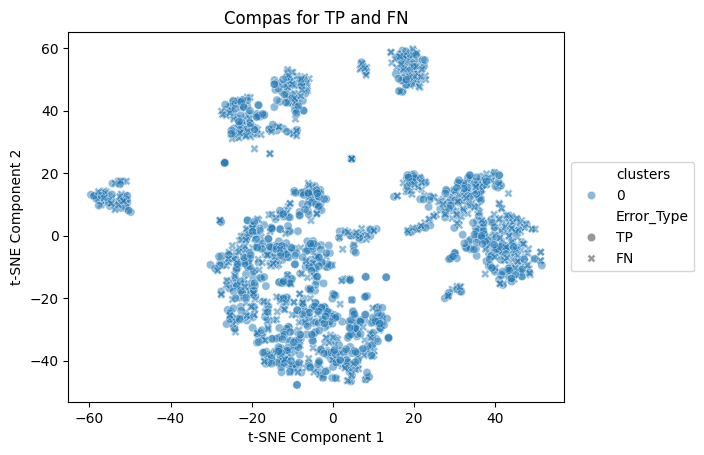

In [103]:
#pca_plot(TPFN_init, 'Compas for TP and FN', 0.6)
tsne_plot(TPFN_init, 'Compas for TP and FN', 30, 200, 1000)

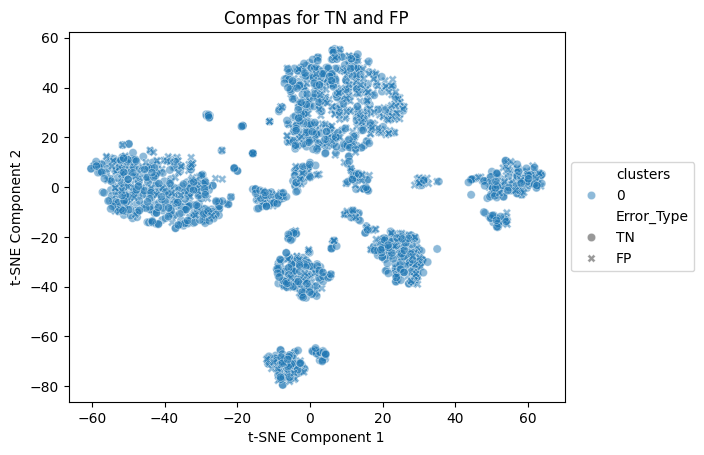

In [104]:
#pca_plot(TNFP_init, 'Compas for TN and FP', 0.6)
tsne_plot(TNFP_init, 'Compas for TN and FP', 30, 200, 1000)

# UTILS FOR CLUSTERING

In [105]:
#get cluster with max error difference
def get_max_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all', function = get_error_diff):
  max_bias = 0 #min possible bias
  max_bias_cluster = -2

  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue

    current_bias = function(data, cluster_id, cluster_col, bias_type, baseline) #pos function to find highest bias

    if current_bias > max_bias:
      max_bias = current_bias
      max_bias_cluster = cluster_id

    return(max_bias_cluster, max_bias)

#get cluster with min error difference
def get_min_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all'):
  min_bias = 1 #max possible bias and look for smt smaller
  min_bias_cluster = -2

  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue
    current_bias = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline)
    if current_bias < min_bias:
      min_bias = current_bias
      min_bias_cluster = cluster_id
  return(min_bias_cluster, min_bias)

#get size of the smallest cluster
def get_min_cluster_size(data, cluster_col = 'new_clusters'):
  min_cluster_size = len(data)
  for i in data['new_clusters'].unique():
    if i == -1: #exclude the -1 clusters as they may present outliers (in dbscan?)
      continue
      size = len(data.loc[data['new_clusters'] == i])
      if size < min_cluster_size: #update if new cluster size is smaller
        min_cluster_size = size
  return(min_cluster_size)

def get_random_cluster(data, cluster_col, min_splittable_cluster_size, previous_cluster, all_cluster_ids):
  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1 or candidate_cluster_id == previous_cluster:
      continue
      print ('This is the random cluster we picked:', candidate_cluster_id)

      candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]
      if len(candidate_cluster) >= min_splittable_cluster_size:
        print('it is too small:', len(candidate_cluster))
        continue
      else:
        return candidate_cluster_id

def select_new_cluster(data, cluster_col='clusters', error_column='errors', overall_error_rate=0.5, bias_type='negative', baseline='all'):
    smallest_diff = float('inf')
    selected_cluster = None

    for cluster_id in data[cluster_col].unique():
        if cluster_id == -1: #skip outlier
            continue

        error_diff = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline) #calculate the error_diff for each cluster

        if error_diff is None:
            continue

        abs_diff = abs(overall_error_rate - (get_error_rate(data[data[cluster_col] == cluster_id]))) #get cluster with the smallest absolute difference with the overall error rate (0.5)

        if abs_diff < smallest_diff:
            smallest_diff = abs_diff
            selected_cluster = cluster_id
    return selected_cluster

def exit_clustering(data, msg='', bias_type='', iter=''):
  print('Iteration ', iter, ': ', msg)
  print('Overall error rate: ', get_error_rate(data))
  for c in np.sort(data['clusters'].unique()):
    print('Cluster: ', c, '\tSize: ', len(data.loc[data['clusters'] == c]), '\tError rate: ', get_error_rate(data.loc[data['clusters'] == c]))
  pca_plot(data,'HBAC-DBSCAN on COMPAS - ' + bias_type + ' bias', hue='clusters', s=15, alpha=0.8)
  return data


# K-MEANS CLUSTERING

In [121]:
def hbac_kmeans(data, error='FN', max_iter=300, show_plot=True):
    clus_model_kwargs = {
        "n_clusters": 2,  # Nr of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Number of initializations
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    x = 0  # Initial cluster number
    initial_bias = 0  # Initial bias value

    error_list = []
    error_rate = get_error_rate(data, column=error)  # Calculating mean error rate on the specified error column

    min_splittable_cluster_size = round(0.05 * len(data))  # Min size of cluster to be split
    min_acceptable_cluster_size = round(0.03 * len(data))  # Min acceptable size of cluster after split
    print("error rate:", error_rate)

    # Iterative clustering loop
    for i in range(1, max_iter):
        if len(data['clusters'].unique()) != 1:  # Check for multiple clusters
            error_list.append(get_error_rate(data, column=error))  # Calculate and store error rate
            data['new_clusters'] = -1  # Reset new clusters
        candidate_cluster = data.loc[data['clusters'] == x]  # Select subset data for the current cluster

        if len(candidate_cluster) < min_splittable_cluster_size:  # Check for size
            x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())
            continue

        # Select only numeric columns for K-means
        numeric_columns = candidate_cluster.select_dtypes(include=[np.number]).columns
        kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster[numeric_columns].drop(columns=META_COL + ERROR_COL, errors='ignore'))

        candidate_cluster['new_clusters'] = pd.DataFrame(
            kmeans.predict(candidate_cluster[numeric_columns].drop(columns=META_COL + ERROR_COL, errors='ignore')),
            index=candidate_cluster.index)
        data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters']) # Combine new clusters with existing ones

        discr_bias = get_error_diff(data, x, 'clusters', bias_type='negative', baseline='all')  # Determine discriminative bias
        print('discriminative bias:', discr_bias)

        min_cluster_size = get_min_cluster_size(data)
        print('Smallest cluster size:', min_cluster_size)

        if (discr_bias >= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
            print("adding a new cluster")
            n_cluster = max(data['clusters'])
            data['clusters'][data['new_clusters'] == 1] = n_cluster + 1

            if show_plot:
                tsne_plot(data, error_type=error, perplexity=30, learning_rate=200, n_iter=1000, alpha=0.5)
                plt.show()

            x = select_new_cluster(data, error_column=error)
            initial_bias = discr_bias

        else:
            x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())

    print('MAX_ITER')
    print(error_list)
    return data

TP FN DATA

error rate: 0.42290748898678415
discriminative bias: 0.0
Smallest cluster size: 1589
adding a new cluster


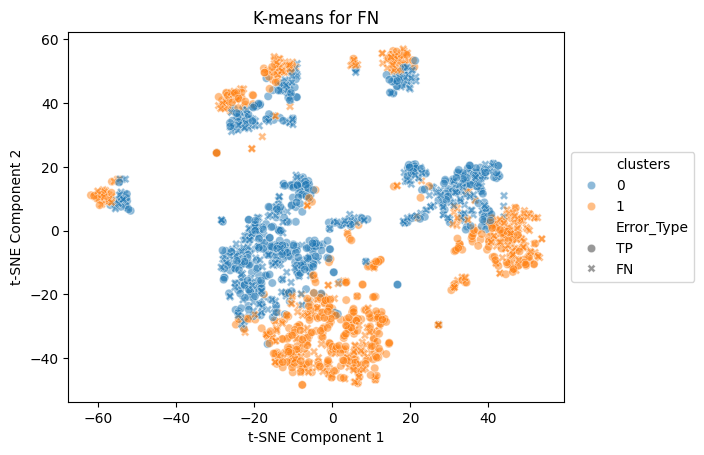

discriminative bias: 0.007092511013215841
Smallest cluster size: 1589
adding a new cluster


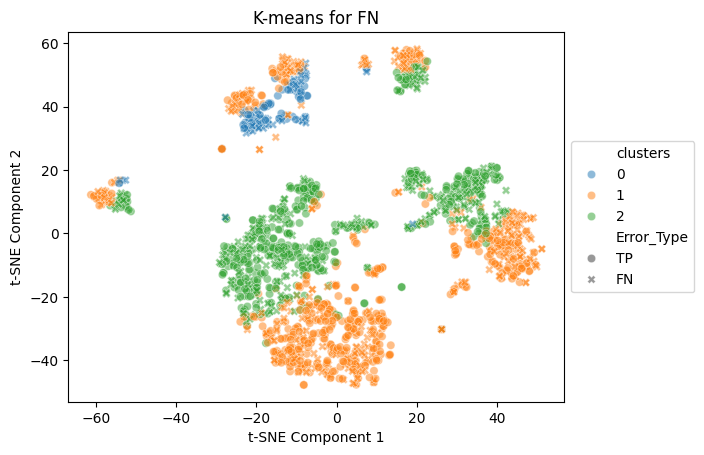

discriminative bias: 0.12627283888206836
Smallest cluster size: 1589
adding a new cluster


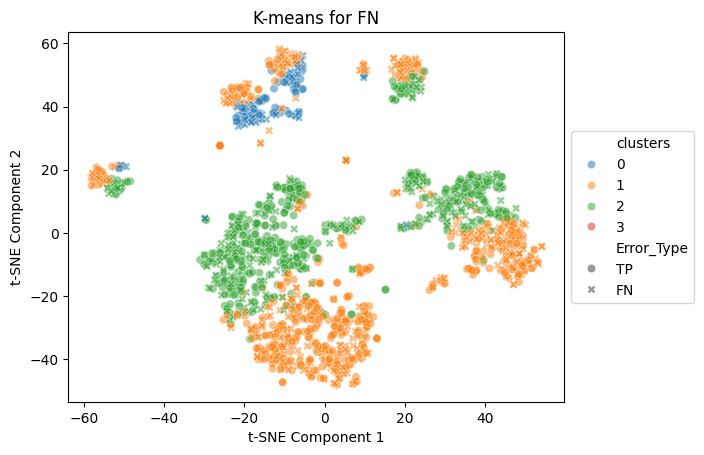

discriminative bias: 0.1308115192776787
Smallest cluster size: 1589
adding a new cluster


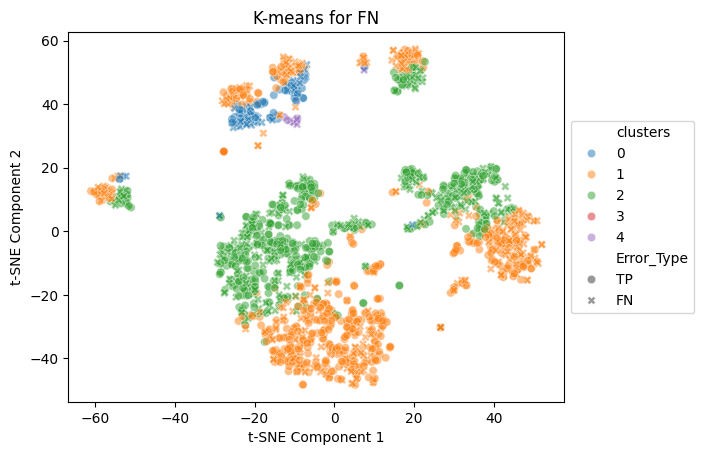

discriminative bias: 0.10920260275633514
Smallest cluster size: 1589
MAX_ITER
[0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.42290748898678415, 0.4229074889867841

In [122]:
TPFN_init = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_classes=True)
hbac_kmeans(data = TPFN_init, error= 'FN', max_iter = 300, show_plot= True)
plt.show()

In [124]:
c= get_max_bias_cluster(TPFN_init)
#highest_bias_cluster = TP_FN[TP_FN['clusters']==c]
#len(highest_bias_cluster)

Mean_error_rate_TPFN = get_error_rate(TPFN_init)

print ('Mean error rate of full TPFN data set:', Mean_error_rate_TPFN)

print (f" cluster {c} has the highest discrimination bias for TPFN data")


Mean error rate of full TPFN data set: 0.42290748898678415
 cluster (-2, 0) has the highest discrimination bias for TPFN data


TN FP DATA

error rate: 0.33026584867075665
discriminative bias: 0.0
Smallest cluster size: 1956
adding a new cluster


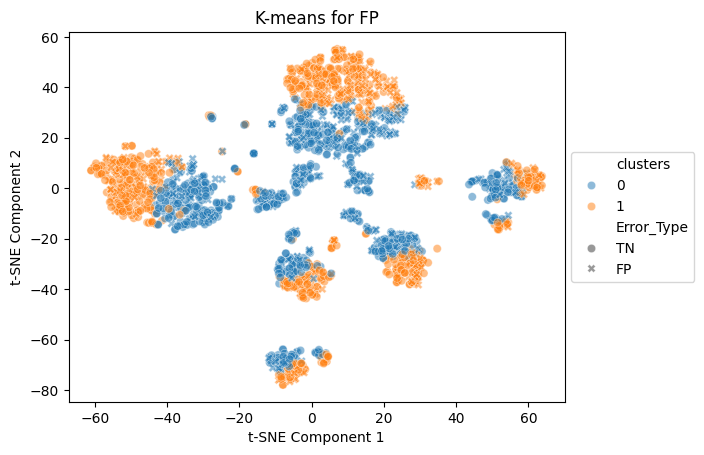

discriminative bias: 0.0033994899746616625
Smallest cluster size: 1956
adding a new cluster


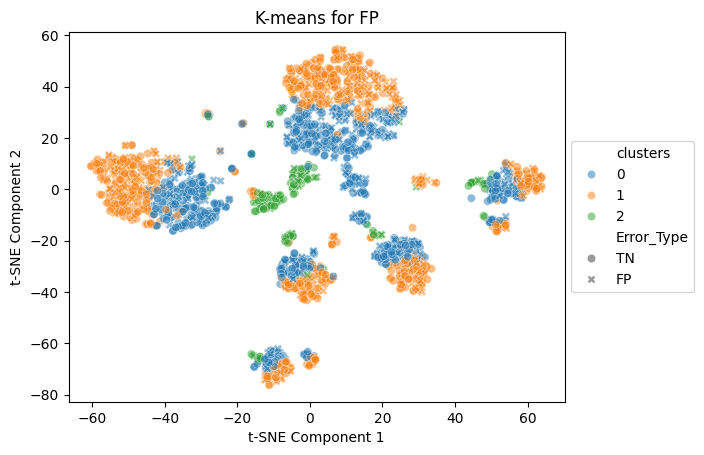

discriminative bias: 0.006998302272639589
Smallest cluster size: 1956
adding a new cluster


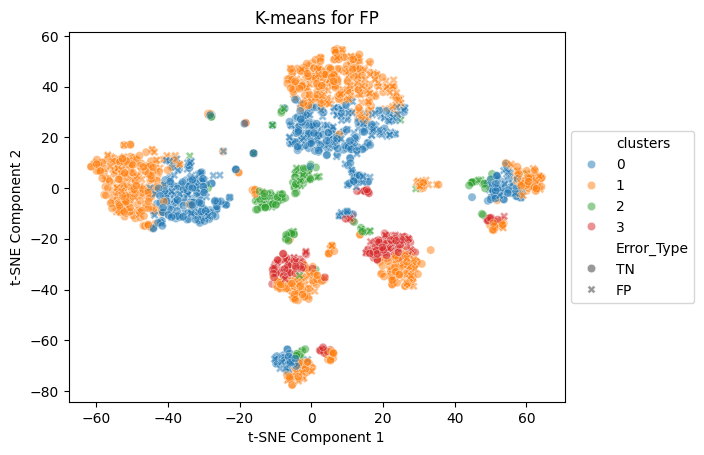

discriminative bias: 0.03903506318334671
Smallest cluster size: 1956
adding a new cluster


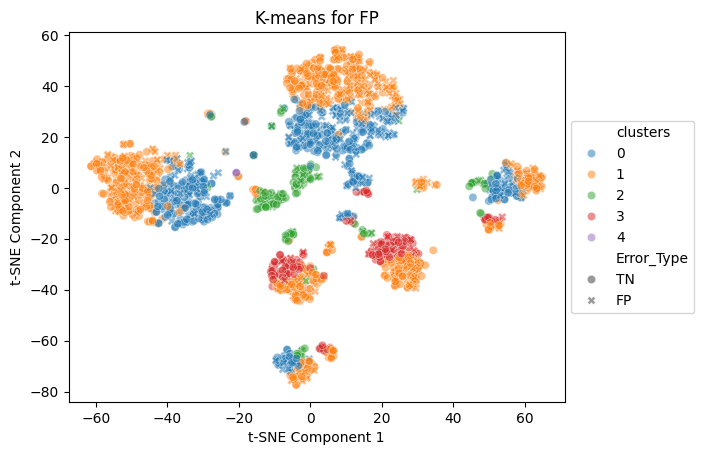

discriminative bias: 0.04072651774145708
Smallest cluster size: 1956
adding a new cluster


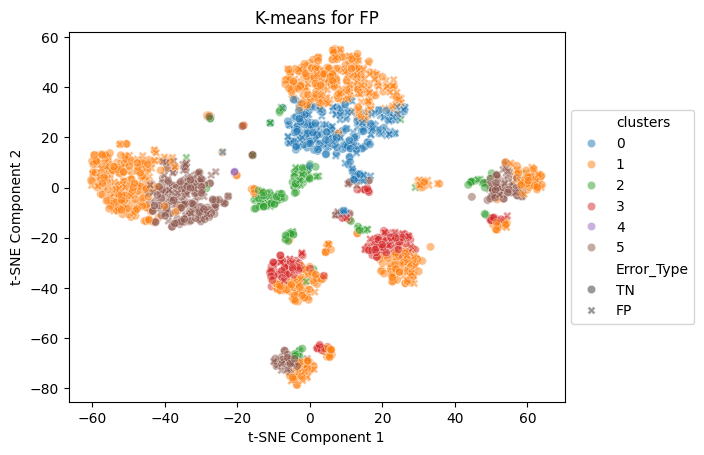

discriminative bias: 0.1498666016603692
Smallest cluster size: 1956
adding a new cluster


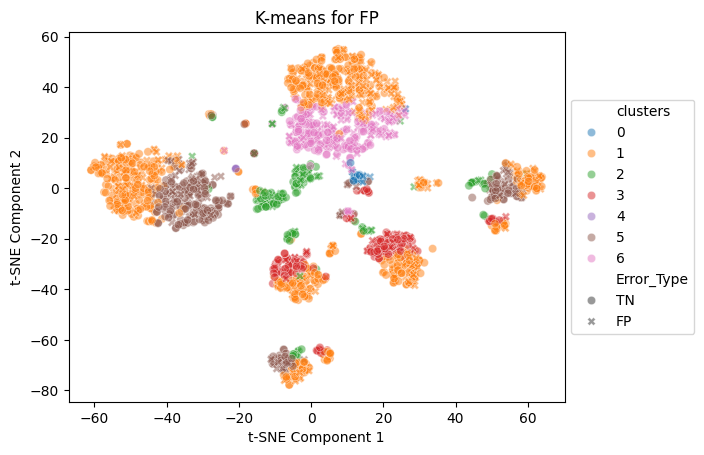

discriminative bias: 0.15002088968049782
Smallest cluster size: 1956
adding a new cluster


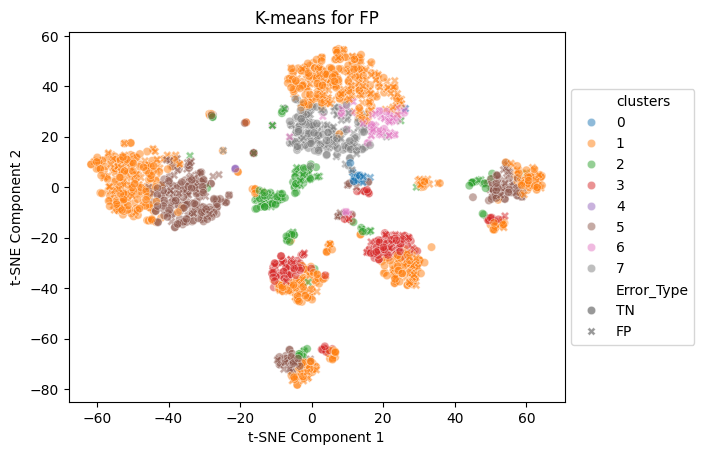

MAX_ITER
[0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.33026584867075665, 0.3

In [127]:
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_classes=True)
hbac_kmeans(data = TNFP_init, error= 'FP', max_iter = 300, show_plot= True)
plt.show()

In [128]:
c= get_max_bias_cluster(TNFP_init)

Mean_error_rate_TNFP = get_error_rate(TNFP_init)

print ('Mean error rate of full TNFP data set:', Mean_error_rate_TNFP)

print (f" cluster {c} has the highest discrimination bias for TNFP data")


Mean error rate of full TNFP data set: 0.33026584867075665
 cluster (-2, 0) has the highest discrimination bias for TNFP data


# ANOVA SIGNIFICANCE TESTING

In [129]:
'''SHAP, ERROR & BASIC COLUMNS FOR TPFN ANOVA'''
groupstpfn = TPFN_init.groupby('clusters')['FN'].apply(list)
anovatpfn = [np.array(groupstpfn) for groupstpfn in groupstpfn]

f_stat, p_val = f_oneway(*anovatpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 3.028212584344244
p-value: 0.0168066265262342
there are statistically significant differences between the clusters.


In [130]:
'''SHAP, ERROR & BASIC COLUMNS FOR TNFP ANOVA'''
groupstnfp = TNFP_init.groupby('clusters')['FP'].apply(list)
anovatnfp = [np.array(groupstnfp) for groupstnfp in groupstnfp]

f_stat, p_val = f_oneway(*anovatnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 13.362755339896394
p-value: 6.144182770139384e-17
there are statistically significant differences between the clusters.


# SHAP AND ERROR NO FEATURES


**RQ1: is there a relationshop between shap & risk of error?**

TP_FN & TN_FP = *all columns* (above)

SE = shap and error columns

FE = all columns except shap (selma)


--------------------------------------------------
**RQ2: does shap help in finding disc clusters?**

FS = all columns except error

S = only SHAP_COL

F = only BASIC_COL


In [ ]:
'''SE DF: Shap and Error '''
SE_tpfn_ = TPFN_data[META_COL + SHAP_COL]
SE_tnfp_ = TNFP_data[META_COL + SHAP_COL]
#SE_tnfp_.drop('Error_Type', axis = 1)

SE_tpfn = initialize_dataset(SE_tpfn_)
SE_tnfp = initialize_dataset(SE_tnfp_)

SE_tpfn.info()
SE_tnfp.info()

In [ ]:
hbac_kmeans(data = SE_tnfp, max_iter = 300, show_plot= False)
hbac_kmeans(data = SE_tpfn, max_iter = 300, show_plot= False)

In [ ]:
'''SHAP & ERROR COLUMNS FOR TPFN ANOVA'''
groupsSE_tpfn = SE_tpfn.groupby('clusters')['FN'].apply(list)
anovaSE_tpfn = [np.array(groupsSE_tpfn) for groupsSE_tpfn in groupsSE_tpfn]

f_stat, p_val = f_oneway(*anovaSE_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

In [ ]:
'''SHAP & ERROR COLUMNS FOR TNFP ANOVA'''
groupsSE_tnfp = SE_tnfp.groupby('clusters')['FP'].apply(list)
anovaSE_tnfp = [np.array(groupsSE_tnfp) for groupsSE_tnfp in groupsSE_tnfp]

f_stat, p_val = f_oneway(*anovaSE_tnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

# ERROR AND FEATURES NO SHAP

In [ ]:
'''FE_df: FEATURES AND ERROR NO SHAP (Selma) '''

FE_tpfn_ = TPFN_data.drop(SHAP_COL, axis = 1) #[BASIC_COL + META_COL + DUMMY_RACE + DUMMY_GENDER]
FE_tnfp_ = TNFP_data.drop(SHAP_COL, axis = 1) #[BASIC_COL + META_COL + DUMMY_RACE + DUMMY_GENDER]

FE_tpfn = initialize_dataset(FE_tpfn_)
FE_tnfp = initialize_dataset(FE_tnfp_)

#FE_tpfn_.info()
FE_tpfn.info()
#FE_tnfp.info()
#FE_tnfp_.info()